In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats
import numpy as np
import sys
import seaborn as sns
import pyprojroot
import importlib
import janitor
import pyreadr
sys.path.append(str(pyprojroot.here()))
import src.utils
import src.pandas_missing_extension
importlib.reload(src.pandas_missing_extension)
importlib.reload(src.utils)
from src.utils import load_and_clean_nhanes_data

In [7]:
nhanes_df = load_and_clean_nhanes_data()
nhanes_df.head()

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male


### Consideration and Evaluation of Different Types of Missing Values

If the missing values are MCAR (Missing Completely at Random), you can apply deletion or imputation without introducing bias.

If they are MAR (Missing at Random), deletion may introduce bias, so imputation—either single or multiple—is recommended.

If they are MNAR (Missing Not at Random), imputation may not be sufficient, and it is necessary to model the missingness mechanism or collect more data.

# Evaluation of the Missing Values Mechanism Using t-Test

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Information</b>
    <p>
<code>two-sided</code>: The <b>means</b> of the distributions underlying the samples are <b>unequal</b>.<br>
<code>less</code>: The <b>mean</b> of the distribution underlying the <b>first</b> sample is <b>less</b> than the mean of the distribution underlying the <b>second</b> sample.<br>
<code>greater</code>: The <b>mean</b> of the distribution underlying the <b>first</b> sample is <b>greater</b> than the mean of the distribution underlying the <b>second</b> sample.<br>
    </p>
</div>

In [8]:
female_weight, male_weight = nhanes_df.select_columns(
    "gender", "weight"
).transform_column(
    "weight",
    lambda x: x.isna(),
    elementwise=False
).groupby(
    "gender"
).weight.pipe(
    lambda df: (
        df.get_group("Female"),
        df.get_group("Male")
    )
)

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


In [9]:
scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

t-statistic = -0.362: The difference in the proportion of missing values between both groups is small and negative, suggesting that women may have a slightly higher rate of missing values, but not significantly.

p-value = 0.717: This value is high (> 0.05), indicating that there is not enough statistical evidence to claim that the proportions of missing values differ between the two groups.

We cannot reject the null hypothesis, suggesting that the missing values in "weight" do not depend on gender. This is an indication that the missing values could be MCAR (Missing Completely at Random).

#### Learning about mosaic graph

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


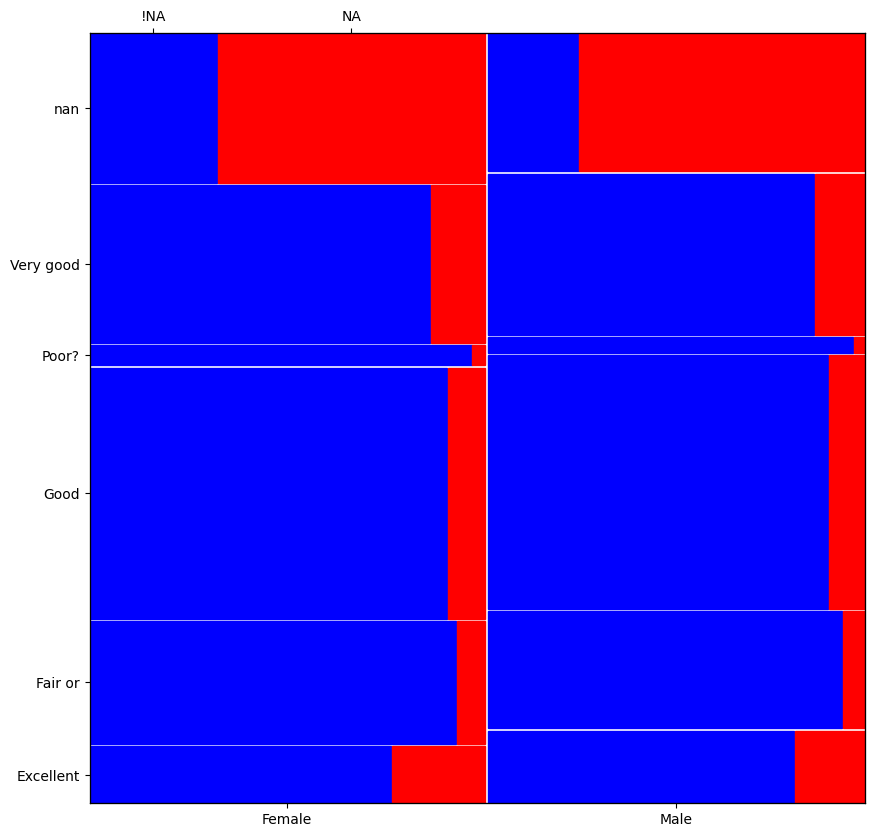

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "blue"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

#### Challenge: add this function to pandas missing extension

/home/alex/anaconda3/envs/handling_missing_data/lib/python3.10/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


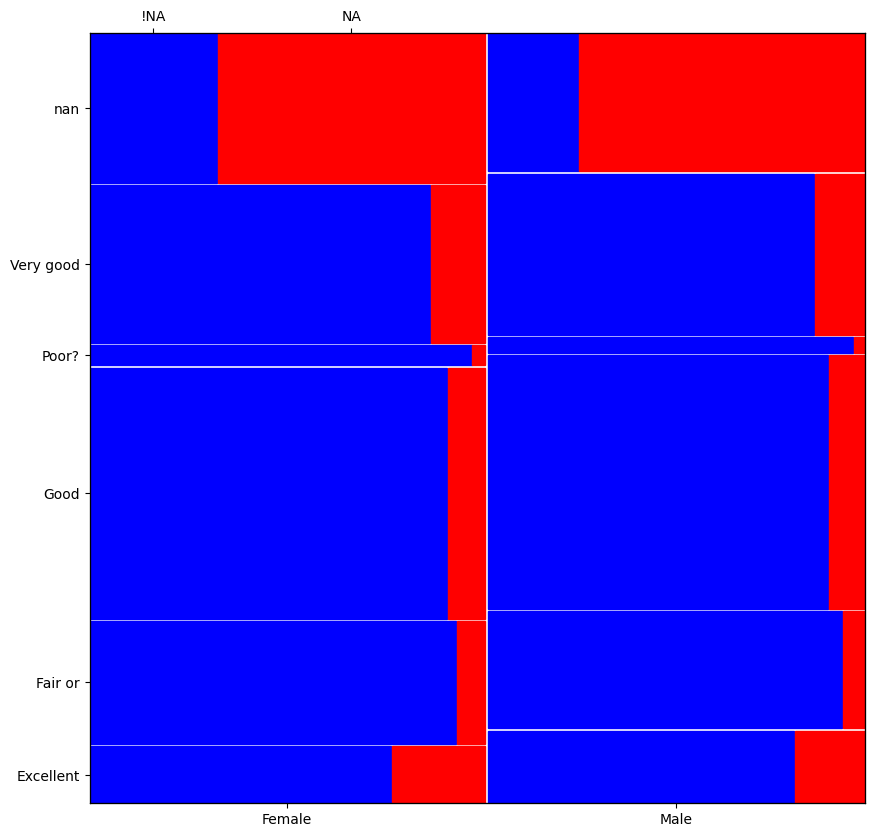

In [12]:
nhanes_df.missing.missing_mosaic_plot("weight", "general_health_condition", "gender")